In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
%cd /kaggle/working
!git clone https://github.com/ultralytics/ultralytics.git
%cd ultralytics
!pip install -e .

/kaggle/working
Cloning into 'ultralytics'...
remote: Enumerating objects: 59621, done.
remote: Counting objects: 100% (1117/1117), done.
remote: Compressing objects: 100% (575/575), done.
remote: Total 59621 (delta 930), reused 555 (delta 542), pack-reused 58504 (from 5)
Receiving objects: 100% (59621/59621), 32.69 MiB | 25.47 MiB/s, done.
Resolving deltas: 100% (44222/44222), done.
/kaggle/working/ultralytics
Obtaining file:///kaggle/working/ultralytics
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB

In [2]:
import ultralytics
print("✅ Ultralytics path:", ultralytics.__file__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Ultralytics path: /kaggle/working/ultralytics/ultralytics/__init__.py


In [3]:
mkdir -p /kaggle/working/ultralytics/ultralytics/cfg/models/9/


In [4]:
cp /kaggle/working/ultralytics/ultralytics/cfg/models/v9/yolov9m.yaml /kaggle/working/ultralytics/ultralytics/cfg/models/9/yolo9_new1.yaml


In [15]:
import shutil

# -------------------- SETUP --------------------

# Paths
original_yaml = '/kaggle/working/ultralytics/ultralytics/cfg/models/v9/yolov9m.yaml'
new_yaml = '/kaggle/working/ultralytics/ultralytics/cfg/models/9/yolo9_new1.yaml'

# Copy original YAML to a new file for modifications
shutil.copyfile(original_yaml, new_yaml)

# Read the original YAML content
with open(new_yaml, 'r') as f:
    lines = f.readlines()

# -------------------- MASTER EDIT ZONE --------------------

# ✅ 1️⃣ Update the number of classes (if necessary)
for i, line in enumerate(lines):
    if line.strip().startswith("nc:"):
        lines[i] = "nc: 13  # number of classes \n"
        break

# ✅ 2️⃣ Replace Backbone section
# Locate the "backbone:" and "head:" sections in the YAML
backbone_start = next(i for i, line in enumerate(lines) if "backbone:" in line) + 1
head_start = next(i for i, line in enumerate(lines) if "head:" in line)

# Define the new custom backbone with strategic ResBlocks
new_backbone = [
    "  - [-1, 1, Conv, [32, 3, 2]] # 0-P1/2\n",
    "  - [-1, 1, Conv, [64, 3, 2]] # 1-P2/4\n",
    "  - [-1, 1, RepNCSPELAN4, [128, 128, 64, 1]] # 2\n",
    "  - [-1, 1, AConv, [240]] # 3-P3/8\n",
    "  - [-1, 1, RepNCSPELAN4, [240, 240, 120, 1]] # 4\n",
    "  - [-1, 1, AConv, [360]] # 5-P4/16\n",
    "  - [-1, 1, ResBlock, [360]] # 6 Key ResBlock after P4\n",  # 🔥 Key ResBlock
    "  - [-1, 1, RepNCSPELAN4, [360, 360, 180, 1]] # 7\n",
    "  - [-1, 1, AConv, [480]] # 8-P5/32\n",
    "  - [-1, 1, RepNCSPELAN4, [480, 480, 240, 1]] # 9\n",
    "  - [-1, 1, SPPELAN, [480, 240]] # 10\n",
]

# Replace the old backbone lines
lines = lines[:backbone_start] + new_backbone + lines[head_start:]

# ✅ 3️⃣ Replace Head section
# Locate the start of the head section in the YAML
head_start = next(i for i, line in enumerate(lines) if "head:" in line) + 1

# Define the new custom head with strategic ResBlocks
new_head = [
    "  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]\n",
    "  - [[-1, 7], 1, Concat, [1]] # cat backbone P4\n",
    "  - [-1, 1, Conv, [360, 1, 1]] # Reduce to 360 channels\n",
    "  - [-1, 1, RepNCSPELAN4, [360, 360, 180, 1]] # 13\n",
    
    "  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]\n",
    "  - [[-1, 4], 1, Concat, [1]] # cat backbone P3\n",
    "  - [-1, 1, Conv, [240, 1, 1]] # Reduce to 240 channels\n",
    "  - [-1, 1, ResBlock, [240]] # 16 Key ResBlock before P3 output\n",  # 🔥 Key ResBlock
    "  - [-1, 1, RepNCSPELAN4, [240, 240, 120, 1]] # 17 (P3/8-small)\n",
    
    "  - [-1, 1, AConv, [180]]\n",
    "  - [[-1, 13], 1, Concat, [1]] # cat head P4\n",
    "  - [-1, 1, Conv, [360, 1, 1]] # Reduce to 360 channels\n",
    "  - [-1, 1, RepNCSPELAN4, [360, 360, 180, 1]] # 20 (P4/16-medium)\n",
    
    "  - [-1, 1, AConv, [240]]\n",
    "  - [[-1, 10], 1, Concat, [1]] # cat head P5\n",
    "  - [-1, 1, RepNCSPELAN4, [480, 480, 240, 1]] # 23 (P5/32-large)\n",
    
    "  - [[17, 20, 23], 1, Detect, [nc]] # Detect(P3, P4, P5)\n",
]

# Replace the old head lines
lines = lines[:head_start] + new_head

# ✅ 4️⃣ Save the modified YAML
with open(new_yaml, 'w') as f:
    f.writelines(lines)

print("✅ YAML fully rebuilt with strategic ResBlocks placement!")

# -------------------- OPTIONAL CHECKS --------------------
# ✅ Validate the model loads correctly before training
from ultralytics import YOLO

try:
    model = YOLO(new_yaml)
    print("✅ Model loaded successfully!")
    model.info()  # Display model summary
except Exception as e:
    print("❌ Model loading failed:", e)


✅ YAML fully rebuilt with strategic ResBlocks placement!
✅ Model loaded successfully!
YOLO9_new1 summary: 368 layers, 23,048,583 parameters, 23,048,567 gradients, 101.9 GFLOPs


In [16]:
#verify yaml file content

with open('/kaggle/working/ultralytics/ultralytics/cfg/models/9/yolo9_new1.yaml', 'r') as f:
    content = f.read()

print(content)

# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

# YOLOv9m object detection model with P3/8 - P5/32 outputs
# Model docs: https://docs.ultralytics.com/models/yolov9
# Task docs: https://docs.ultralytics.com/tasks/detect
# 348 layers, 20216160 parameters, 77.9 GFLOPs

# Parameters
nc: 13  # number of classes 

# GELAN backbone
backbone:
  - [-1, 1, Conv, [32, 3, 2]] # 0-P1/2
  - [-1, 1, Conv, [64, 3, 2]] # 1-P2/4
  - [-1, 1, RepNCSPELAN4, [128, 128, 64, 1]] # 2
  - [-1, 1, AConv, [240]] # 3-P3/8
  - [-1, 1, RepNCSPELAN4, [240, 240, 120, 1]] # 4
  - [-1, 1, AConv, [360]] # 5-P4/16
  - [-1, 1, ResBlock, [360]] # 6 Key ResBlock after P4
  - [-1, 1, RepNCSPELAN4, [360, 360, 180, 1]] # 7
  - [-1, 1, AConv, [480]] # 8-P5/32
  - [-1, 1, RepNCSPELAN4, [480, 480, 240, 1]] # 9
  - [-1, 1, SPPELAN, [480, 240]] # 10
head:
  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 7], 1, Concat, [1]] # cat backbone P4
  - [-1, 1, Conv, [360, 1, 1]] # Reduce to 360 channels
  - [-1, 

In [17]:
#register res block
init_path = '/kaggle/working/ultralytics/ultralytics/nn/__init__.py'

with open(init_path, 'r') as f:
    lines = f.readlines()

# Add import if not already present
if "from ultralytics.nn.modules.resblock import ResBlock" not in ''.join(lines):
    lines.append("\nfrom ultralytics.nn.modules.resblock import ResBlock\n")

with open(init_path, 'w') as f:
    f.writelines(lines)

print("✅ ResBlock registered in __init__.py")

✅ ResBlock registered in __init__.py


In [18]:
#verify yaml file content

with open('/kaggle/working/ultralytics/ultralytics/nn/__init__.py', 'r') as f:
    content = f.read()

print(content)

# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

from .tasks import (
    BaseModel,
    ClassificationModel,
    DetectionModel,
    SegmentationModel,
    attempt_load_one_weight,
    attempt_load_weights,
    guess_model_scale,
    guess_model_task,
    parse_model,
    torch_safe_load,
    yaml_model_load,
)

__all__ = (
    "attempt_load_one_weight",
    "attempt_load_weights",
    "parse_model",
    "yaml_model_load",
    "guess_model_task",
    "guess_model_scale",
    "torch_safe_load",
    "DetectionModel",
    "SegmentationModel",
    "ClassificationModel",
    "BaseModel",
)

from ultralytics.nn.modules.resblock import ResBlock



In [19]:
resblock_code = '''
import torch
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.act1 = nn.SiLU(inplace=True)

        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        self.skip = nn.Identity()
        self.act2 = nn.SiLU(inplace=True)

    def forward(self, x):
        identity = self.skip(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        return self.act2(out)
'''

# Write to file
resblock_path = '/kaggle/working/ultralytics/ultralytics/nn/modules/ResBlock.py'
with open(resblock_path, 'w') as f:
    f.write(resblock_code)

print("✅ ResBlock defined and saved to ResBlock.py")

✅ ResBlock defined and saved to ResBlock.py


In [20]:
#verify res block

with open('/kaggle/working/ultralytics/ultralytics/nn/modules/ResBlock.py', 'r') as f:
    content = f.read()

print(content)


import torch
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.act1 = nn.SiLU(inplace=True)

        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        self.skip = nn.Identity()
        self.act2 = nn.SiLU(inplace=True)

    def forward(self, x):
        identity = self.skip(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        return self.act2(out)



In [21]:
# Import and inject ResBlock directly into the correct global space
import ultralytics.nn.tasks as tasks
from ultralytics.nn.modules.ResBlock import ResBlock

# Manually register the class into the YOLO parsing scope
setattr(tasks, 'ResBlock', ResBlock)

# Now build your model
from ultralytics import YOLO
model = YOLO('/kaggle/working/ultralytics/ultralytics/cfg/models/9/yolo9_new1.yaml')
print("✅ Model with ResBlock built successfully.")

✅ Model with ResBlock built successfully.


In [ ]:
print(model)

In [22]:
# Optional: Test with dummy input
import torch
dummy_input = torch.randn(1, 3, 640, 640)
_ = model.model(dummy_input)  # Should not throw any errors

print("✅ Dummy input passed through model successfully.")

✅ Dummy input passed through model successfully.


In [23]:
data_yaml_path = '/kaggle/input/yamlfile3/data (3).yaml'

In [24]:
from ultralytics import YOLO

# Load your custom YOLOv9 with ResBlock
model = YOLO('/kaggle/working/ultralytics/ultralytics/cfg/models/9/yolo9_new1.yaml')

# Train with your required settings
model.train(
    data="/kaggle/input/yamlfile3/data (3).yaml",  # ✅ Update this to your actual dataset.yaml path
    epochs=100,
    batch=16,
    imgsz=640,
    save=True,
    cache=True,
    device=0,  # GPU
    optimizer="AdamW",
    project="/kaggle/working/yolov9_res_results",
    name="clcxray_resblock",
    pretrained=False  #since it's a custom model
)

print("✅ Training started: YOLOv9m-ResBlock (100 epochs)")

Ultralytics 8.3.134 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/yamlfile3/data (3).yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/ultralytics/ultralytics/cfg/models/9/yolo9_new1.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=clcxray_resblock2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overla

train: Scanning /kaggle/input/clc-xrayy/train/labels... 3186 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3186/3186 [00:03<00:00, 911.22it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/clc-xrayy/train is not writeable, cache not saved.
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (2.9GB RAM): 100%|██████████| 3186/3186 [00:06<00:00, 524.94it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6.4±2.3 MB/s, size: 32.1 KB)


val: Scanning /kaggle/input/clc-xrayy/valid/labels... 956 images, 0 backgrounds, 0 corrupt: 100%|██████████| 956/956 [00:04<00:00, 194.95it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/clc-xrayy/valid is not writeable, cache not saved.
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.9GB RAM): 100%|██████████| 956/956 [00:01<00:00, 550.31it/s]


Plotting labels to /kaggle/working/yolov9_res_results/clcxray_resblock2/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 156 weight(decay=0.0), 163 weight(decay=0.0005), 162 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/yolov9_res_results/clcxray_resblock2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.41G      2.821      3.492      3.122          5        640: 100%|██████████| 200/200 [02:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:18<00:00,  1.65it/s]


                   all        956       2317       0.22      0.274     0.0682     0.0223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.47G      2.138      2.761      2.638          6        640: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]


                   all        956       2317      0.184      0.427      0.227     0.0957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       8.5G      1.943      2.418       2.48          6        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.83it/s]


                   all        956       2317      0.263      0.386      0.262      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.49G      1.791       2.24       2.31          6        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.84it/s]

                   all        956       2317      0.405      0.433      0.365      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.51G      1.663      2.043      2.177          7        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.83it/s]

                   all        956       2317       0.61      0.498      0.482      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       8.5G      1.601      1.952      2.112         10        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.459      0.476      0.427      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.51G      1.555      1.875      2.081          4        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.81it/s]

                   all        956       2317      0.563      0.375      0.336      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.52G      1.498      1.807      2.005         10        640: 100%|██████████| 200/200 [02:25<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.83it/s]

                   all        956       2317      0.671      0.503      0.517      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       8.5G      1.439      1.724      1.943          4        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.82it/s]

                   all        956       2317      0.658      0.525      0.563       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       8.5G      1.397      1.651      1.897          2        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.83it/s]

                   all        956       2317      0.623      0.467      0.478      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.51G      1.357      1.568      1.856          8        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.84it/s]

                   all        956       2317      0.568      0.572      0.542      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       8.5G      1.309      1.498      1.817         14        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.655      0.561      0.578      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.52G      1.299       1.46      1.792          8        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.676      0.561      0.608      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.51G      1.269       1.45      1.775          4        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.742      0.622      0.657      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.47G      1.233      1.371      1.731          9        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.723      0.603      0.651       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.52G      1.203       1.33      1.701         13        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.83it/s]

                   all        956       2317      0.729      0.633      0.662      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.51G      1.193      1.326      1.698          5        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.84it/s]

                   all        956       2317      0.695      0.636      0.651      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       8.5G      1.171       1.28       1.68         11        640: 100%|██████████| 200/200 [02:25<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.703      0.627      0.665      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       8.5G      1.141      1.229      1.632         13        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.768      0.638      0.693      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.49G      1.126      1.194       1.62          5        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:15<00:00,  1.88it/s]

                   all        956       2317      0.796       0.65      0.713      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.47G      1.103      1.166      1.605          5        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.737      0.676      0.702      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       8.5G      1.094      1.165      1.595          7        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317        0.7      0.665       0.73      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.49G      1.102      1.143      1.601          6        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.769      0.684      0.723      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       8.5G      1.083      1.122      1.583         13        640: 100%|██████████| 200/200 [02:25<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.745      0.685      0.722      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.47G      1.078      1.124      1.578          5        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.731      0.693      0.727      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.51G      1.061      1.095      1.554          8        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.813      0.672      0.736      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.49G      1.049      1.074      1.548          7        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.738      0.723      0.759      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.51G       1.03      1.048      1.528          8        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.832      0.708      0.761      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.49G      1.035      1.048      1.533          4        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.773      0.671      0.732      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       8.5G      1.032      1.052      1.537          7        640: 100%|██████████| 200/200 [02:25<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.776      0.719      0.761      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       8.5G      1.021       1.03      1.518          7        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.853      0.696      0.764      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.47G      1.005      1.012      1.502         10        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.792       0.71       0.75      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       8.5G     0.9899      1.006      1.497          6        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.834      0.701      0.762      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.49G     0.9937      0.991      1.493          6        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.766      0.722       0.77      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.49G     0.9747     0.9539      1.476          5        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.783       0.73      0.787      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       8.5G     0.9874     0.9729      1.488         14        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.856      0.736        0.8      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       8.5G     0.9683     0.9478      1.473         16        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.747      0.742      0.782      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.47G     0.9549     0.9331      1.463          4        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.808      0.722      0.776      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.49G     0.9516     0.9249      1.458          9        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.822      0.736      0.796      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.51G     0.9385     0.9206      1.453          4        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.84it/s]

                   all        956       2317      0.792      0.761      0.801      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.51G     0.9435     0.9018      1.442         18        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.795      0.761       0.81      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.51G     0.9316     0.8937      1.443         20        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:15<00:00,  1.88it/s]

                   all        956       2317      0.811      0.737      0.798      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.49G     0.9236     0.8653      1.435         18        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.805      0.757      0.802      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.51G     0.9113     0.8523      1.428         20        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.881      0.747      0.805      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       8.5G     0.9087     0.8525      1.421         12        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.779      0.733      0.788      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       8.5G     0.9009     0.8446       1.41          5        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.857      0.746      0.808      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.51G     0.9174     0.8688      1.427         15        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317       0.82      0.748      0.803      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       8.5G     0.9162     0.8722      1.434          8        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.84it/s]

                   all        956       2317      0.832      0.771      0.823      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       8.5G     0.8925     0.8324      1.406          7        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.836      0.768      0.815      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.49G     0.8896     0.8273      1.402         17        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.833      0.775      0.828      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.49G     0.8771     0.8242      1.403         11        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.84it/s]

                   all        956       2317      0.849      0.751       0.81      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.49G     0.8885     0.8291      1.401         12        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.837      0.777      0.825      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.51G     0.8642      0.794      1.376         23        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.848      0.771       0.83      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       8.5G     0.8776     0.8031       1.38         18        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.836      0.774      0.825      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.51G     0.8486     0.7763      1.362         11        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.844      0.788      0.827      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       8.5G     0.8611      0.781      1.375          8        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.858      0.772      0.827      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.51G     0.8524     0.7697      1.362          5        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.846      0.771      0.829      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.49G     0.8549     0.7668       1.37          5        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.879      0.783      0.833      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.51G     0.8374     0.7487      1.352         18        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.828      0.794      0.832      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.49G     0.8484     0.7623      1.367          2        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.875       0.77      0.834      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       8.5G     0.8304     0.7389      1.351         18        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.875      0.783      0.837      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.49G      0.827     0.7424      1.346         11        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.843      0.787      0.834      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       8.5G     0.8294     0.7308      1.344          4        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.824      0.795       0.83      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.49G     0.8271     0.7382       1.34         12        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.871      0.785      0.837      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       8.5G     0.8201     0.7221      1.347          7        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.868      0.781      0.837      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.47G     0.8161     0.7224      1.337         13        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.847      0.785      0.833      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.49G     0.8124     0.7101      1.335          3        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.838      0.781      0.834      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.49G     0.7985     0.6964       1.31         11        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.856      0.773      0.836       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.49G     0.8123     0.7103      1.339          8        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.848      0.793      0.838      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       8.5G     0.7989     0.7037       1.32         12        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317       0.88      0.768      0.836      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       8.5G     0.7933     0.6851      1.319          4        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.876      0.791      0.847      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.51G      0.787      0.678      1.306         13        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.857        0.8      0.839      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.49G     0.7859     0.6806        1.3         20        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.856      0.796      0.846      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       8.5G     0.7799     0.6747      1.299         12        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.874      0.782       0.84      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       8.5G     0.7693     0.6634      1.291          4        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:15<00:00,  1.88it/s]

                   all        956       2317      0.858      0.791      0.847      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.51G      0.784     0.6651      1.297         11        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.862      0.799      0.845      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       8.5G     0.7748     0.6618      1.302         16        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317       0.87      0.792      0.842      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.47G     0.7634     0.6439      1.276         10        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.864      0.786      0.841      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       8.5G     0.7728     0.6594      1.292         12        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.856      0.795      0.844      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.51G     0.7536     0.6458      1.276          4        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.854      0.794       0.84      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.49G     0.7442     0.6338      1.274          2        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.871      0.801      0.849      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.51G     0.7548     0.6407      1.278          1        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.865      0.791      0.847       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.49G     0.7415     0.6235      1.267         11        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.864      0.804      0.849      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.51G      0.735     0.6113      1.262          7        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317       0.84      0.821      0.848      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.49G     0.7393     0.6206      1.261          3        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317       0.86      0.803      0.851      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.51G       0.73     0.6089      1.257         12        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.853      0.811      0.849      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       8.5G      0.729     0.6006      1.249          7        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.858      0.795      0.847      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.48G     0.7247     0.6014      1.257          7        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.867      0.806      0.855      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       8.5G     0.7199     0.5897      1.249          5        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317       0.84      0.815      0.849      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       8.5G     0.7245     0.5926      1.248         12        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.869      0.795      0.849      0.714


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.49G     0.6247     0.4863      1.211          6        640: 100%|██████████| 200/200 [02:27<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.863        0.8      0.846      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.47G     0.6119     0.4733      1.194          8        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.86it/s]

                   all        956       2317      0.867      0.805      0.852      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.47G     0.6039     0.4652      1.191          2        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.84it/s]

                   all        956       2317       0.85      0.821       0.85      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.47G     0.6044     0.4645      1.192          4        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317      0.861      0.815      0.851      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.47G     0.5951     0.4556      1.176          5        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.87it/s]

                   all        956       2317       0.85      0.817      0.849      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.47G     0.5911     0.4533      1.174          3        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:15<00:00,  1.88it/s]

                   all        956       2317      0.867      0.812      0.852      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.47G     0.5817     0.4416      1.167          3        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.861       0.81      0.852       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.47G     0.5801      0.438      1.162          4        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.84it/s]

                   all        956       2317      0.876       0.81      0.852       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.47G     0.5784     0.4372      1.163          4        640: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:15<00:00,  1.88it/s]

                   all        956       2317      0.866      0.808       0.85       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.47G     0.5742     0.4282      1.159          3        640: 100%|██████████| 200/200 [02:26<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.85it/s]

                   all        956       2317      0.866      0.813      0.853      0.722



100 epochs completed in 4.561 hours.
Optimizer stripped from /kaggle/working/yolov9_res_results/clcxray_resblock2/weights/last.pt, 46.6MB
Optimizer stripped from /kaggle/working/yolov9_res_results/clcxray_resblock2/weights/best.pt, 46.6MB

Validating /kaggle/working/yolov9_res_results/clcxray_resblock2/weights/best.pt...
Ultralytics 8.3.134 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO9_new1 summary (fused): 168 layers, 22,902,295 parameters, 0 gradients, 100.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.81it/s]


                   all        956       2317      0.868      0.813      0.853      0.722
                  Cans         83         87      0.908      0.796      0.864      0.766
          CartonDrinks        208        228      0.991      0.949      0.987       0.84
           GlassBottle         32         45      0.312      0.133      0.111     0.0807
         PlasticBottle        462        607      0.896      0.837      0.915       0.78
             SprayCans         87         96      0.737      0.613      0.684      0.568
        SwissArmyKnife        113        114      0.941       0.93      0.953       0.72
                   Tin         82         93      0.918      0.763      0.871      0.738
             VacuumCup        182        192      0.864      0.924      0.937      0.815
                 blade        263        398      0.958      0.922      0.972      0.743
                dagger        121        122      0.941      0.984      0.986      0.891
                 knif

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 12.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/yolov9_res_results/clcxray_resblock2
✅ Training started: YOLOv9m-ResBlock (100 epochs)


In [29]:
import shutil

# Define the folder path and the output zip file path
folder_path = '/kaggle/working/yolov9_res_results/clcxray_resblock2'
output_zip = '/kaggle/working/clcxray_resblock2.zip'

# Create a zip archive
shutil.make_archive(output_zip.replace('.zip', ''), 'zip', folder_path)

print(f"✅ Zipped folder saved as: {output_zip}")


✅ Zipped folder saved as: /kaggle/working/clcxray_resblock2.zip


In [45]:
from ultralytics import YOLO

# Load the trained YOLOv11 model (final weights after 100 epochs)
yolov9_model_path = "/kaggle/input/yolov9mres-best/best.pt"
model = YOLO(yolov9_model_path)

# ✅ Evaluate on test set (split="test" works only if your data.yaml has test defined)
metrics = model.val(
    data="/kaggle/input/yamlfile3/data (3).yaml",
    split="test",  # this line is important
    save_json=True  # optional: saves COCO-format results
)

# 📊 Print detailed evaluation results
print("\n📊 **Test Set Evaluation Results (YOLOv11 (with 2 resnet blocks) - 100 Epochs)**\n")
print(f"Precision   : {metrics.box.p.mean():.4f}")
print(f"Recall      : {metrics.box.r.mean():.4f}")
print(f"F1-Score    : {metrics.box.f1.mean():.4f}")
print(f"mAP@50      : {metrics.box.map50:.4f}")
print(f"mAP@50-95   : {metrics.box.map:.4f}")

Ultralytics 8.3.134 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO9_new1 summary (fused): 168 layers, 22,902,295 parameters, 0 gradients, 100.8 GFLOPs
val: Fast image access ✅ (ping: 0.5±1.0 ms, read: 53.1±23.0 MB/s, size: 35.1 KB)


val: Scanning /kaggle/input/clc-xrayy/test/labels... 956 images, 0 backgrounds, 0 corrupt: 100%|██████████| 956/956 [00:01<00:00, 494.58it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/clc-xrayy/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:29<00:00,  2.06it/s]


                   all        956       1421      0.816      0.609      0.665      0.547
                  Cans         37         47      0.753      0.259      0.388      0.334
          CartonDrinks         46         51      0.833      0.685      0.785      0.602
           GlassBottle         83        109       0.42     0.0459      0.109     0.0764
         PlasticBottle        488        590      0.789      0.651      0.746      0.589
             SprayCans         90        114      0.653      0.114      0.169      0.115
        SwissArmyKnife         17         17      0.922      0.882      0.899      0.677
                   Tin         45         49      0.936      0.571      0.651      0.547
             VacuumCup        314        321      0.885      0.863      0.887      0.792
                 blade         27         34      0.757      0.676      0.675      0.532
                dagger         19         19      0.949      0.895      0.905      0.803
                 knif

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.4ms preprocess, 25.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Saving /kaggle/working/ultralytics/runs/detect/val2/predictions.json...
Results saved to /kaggle/working/ultralytics/runs/detect/val2

📊 **Test Set Evaluation Results (YOLOv11 (with 2 resnet blocks) - 100 Epochs)**

Precision   : 0.8161
Recall      : 0.6086
F1-Score    : 0.6673
mAP@50      : 0.6648
mAP@50-95   : 0.5473


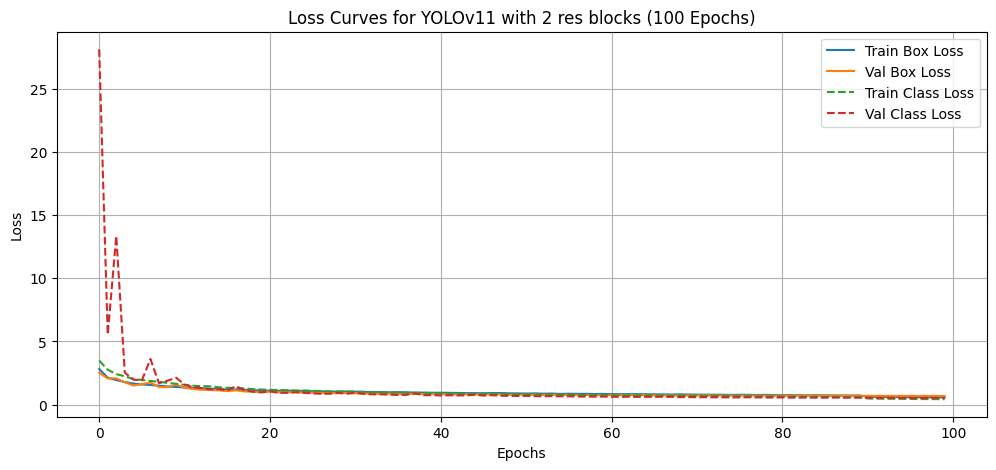

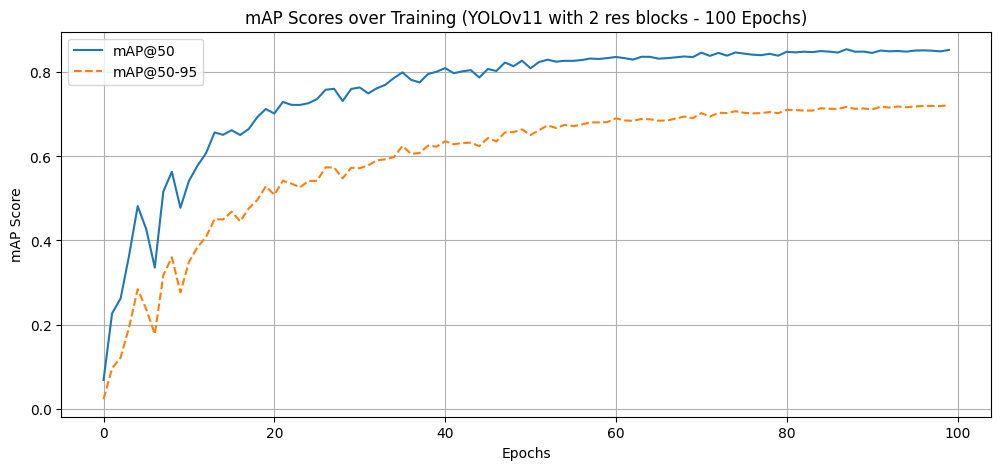

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
# Path to YOLOv11 training logs (results.csv file)
yolov11_results_csv = "/kaggle/input/v9results/results.csv"

# Load training log
df = pd.read_csv(yolov11_results_csv)

# Plot Loss Curves
plt.figure(figsize=(12, 5))
plt.plot(df["train/box_loss"], label="Train Box Loss")
plt.plot(df["val/box_loss"], label="Val Box Loss")
plt.plot(df["train/cls_loss"], label="Train Class Loss", linestyle="dashed")
plt.plot(df["val/cls_loss"], label="Val Class Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves for YOLOv11 with 2 res blocks (100 Epochs)")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy (mAP@50)
plt.figure(figsize=(12, 5))
plt.plot(df["metrics/mAP50(B)"], label="mAP@50")
plt.plot(df["metrics/mAP50-95(B)"], label="mAP@50-95", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("mAP Score")
plt.title("mAP Scores over Training (YOLOv11 with 2 res blocks - 100 Epochs)")
plt.legend()
plt.grid()
plt.show()

In [47]:
# Extract IoU values from training logs
iou_values = df["metrics/mAP50-95(B)"]

# Print Final IoU Score
final_iou = iou_values.iloc[-1]  # Last epoch IoU
print(f"\n🔹 **Final IoU (Intersection over Union): {final_iou:.4f}**")


🔹 **Final IoU (Intersection over Union): 0.7219**


In [48]:
from ultralytics import YOLO

# Load the trained model
model = YOLO("/kaggle/input/yolov9mres-best/best.pt")

# Run prediction on test images
model.predict(
    source="/kaggle/input/clc-xrayy/test/images",  # ✅ path to test images
    save=True,
    save_txt=True,
    project="/kaggle/working/yolov9_predictions",
    name="test_preds",
    imgsz=640,
    conf=0.25
)


image 1/956 /kaggle/input/clc-xrayy/test/images/05_20_27_625_png.rf.1b267931baa1f6e5d48667f95695d374.jpg: 640x608 1 VacuumCup, 56.6ms
image 2/956 /kaggle/input/clc-xrayy/test/images/05_24_05_796_png.rf.6194ae409d5a6b35cae0cea21bab968e.jpg: 640x480 3 PlasticBottles, 48.3ms
image 3/956 /kaggle/input/clc-xrayy/test/images/05_24_40_875_png.rf.9df32b927a67834ac6efc6631c0798d2.jpg: 640x640 1 Tin, 46.1ms
image 4/956 /kaggle/input/clc-xrayy/test/images/05_25_25_703_png.rf.b3ffc7590a2072577e2c6a62a66c73dd.jpg: 640x640 4 PlasticBottles, 1 SprayCans, 2 VacuumCups, 45.1ms
image 5/956 /kaggle/input/clc-xrayy/test/images/05_27_15_406_png.rf.af1ec5b23304c5086affa15bbacd953a.jpg: 640x640 1 VacuumCup, 26.7ms
image 6/956 /kaggle/input/clc-xrayy/test/images/05_29_34_453_png.rf.b4ab31f1dd47ba90e59109ed8fbb45b0.jpg: 352x640 1 SprayCans, 1 VacuumCup, 21.9ms
image 7/956 /kaggle/input/clc-xrayy/test/images/05_34_07_015_png.rf.a3df24d6667e9dd0e02ffbf7bcdea42a.jpg: 416x640 2 CartonDrinkss, 2 GlassBottles, 3 Pl

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'gun-knife-wrench-pilers-scissors', 1: 'Cans', 2: 'CartonDrinks', 3: 'GlassBottle', 4: 'PlasticBottle', 5: 'SprayCans', 6: 'SwissArmyKnife', 7: 'Tin', 8: 'VacuumCup', 9: 'blade', 10: 'dagger', 11: 'knife', 12: 'scissors'}
 obb: None
 orig_img: array([[[244, 236, 169],
         [244, 236, 169],
         [244, 236, 169],
         ...,
         [243, 237, 164],
         [245, 239, 166],
         [245, 239, 166]],
 
        [[244, 236, 169],
         [244, 236, 169],
         [244, 236, 169],
         ...,
         [243, 237, 164],
         [245, 239, 166],
         [245, 239, 166]],
 
        [[244, 236, 169],
         [244, 236, 169],
         [244, 236, 169],
         ...,
         [244, 238, 167],
         [245, 239, 168],
         [245, 239, 168]],
 
        ...,
 
        [[242, 236, 165],
         [242, 236, 165],
         [241, 234,

Total prediction images found: 956


/tmp/ipykernel_35/426287868.py:28: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  plt.tight_layout()


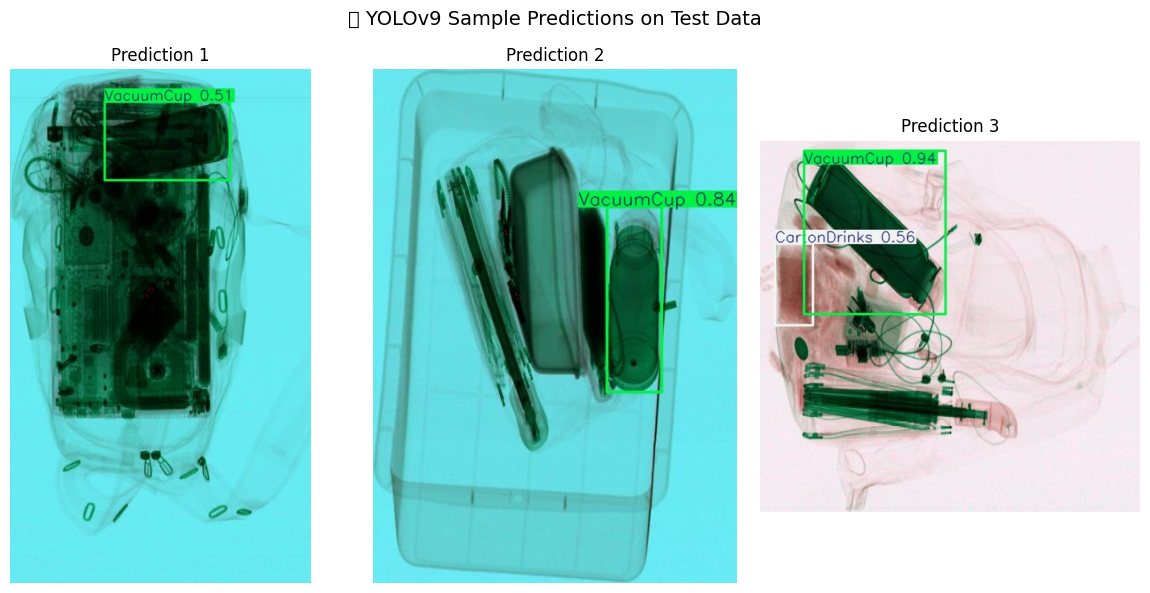

In [56]:
import cv2
import random
import os
import matplotlib.pyplot as plt

# Path where predictions are saved
pred_path = "/kaggle/working/yolov9_predictions/test_preds"  # Usually predictions save inside folder named after `name` arg in predict()

# Get prediction images
image_files = [f for f in os.listdir(pred_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
print(f"Total prediction images found: {len(image_files)}")

# Safely sample up to 3 images
sample_size = min(3, len(image_files))
sample_files = random.sample(image_files, sample_size)

# Plot them
plt.figure(figsize=(12, 6))
for i, file in enumerate(sample_files):
    img = cv2.imread(os.path.join(pred_path, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(f"Prediction {i+1}")
    plt.axis("off")

plt.suptitle("🔹 YOLOv9 Sample Predictions on Test Data", fontsize=14)
plt.tight_layout()
plt.show()
